In [1]:
FOLDER_TEST = "exame-pulmao"
TRAIN_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HMV-HCPA-tf22-all/" + FOLDER_TEST
# VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HMV-vidro/" + FOLDER_TEST
# VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HCPA-vidro/" + FOLDER_TEST
VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HMV-HCPA-tf22-all/" + FOLDER_TEST

# SUB_FILE = ['axis1', 'axis2', 'axis3', 'axis4', 'axis5', 'axis6']
SUB_FILE = ['axis1']
# SUB_FILE = ['axis3', 'axis4']


EPOCHS = 10
IMG_HEIGHT = 256 # 448
IMG_WIDTH = 256 # 448
IMG_CHANNELS = 3
SELECTED_MODEL = ''
NUM_CLASSES = 2
DATA_FOLDER = '20201022/'
LOG_FOLDER = 'logs/' + DATA_FOLDER
TRAINING_FOLDER = 'training/' + DATA_FOLDER
MODEL_FOLDER = 'models/' + DATA_FOLDER
IMAGE_FOLDER = 'images/' + DATA_FOLDER

STRUCTURE_DATASET_FOLDER = "csv/input/"+DATA_FOLDER
OUTPUT_PREDICTED_FOLDER = "csv/output/" + DATA_FOLDER
LABELS = {}

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import glob
import os
from datetime import datetime

import tensorflow as tf
import utilities.plot_metrics as pm

Check if there is available GPU

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:







def get_file_path(folder, search_filter=''):
    '''
    Get all files (full path) contained in a PATH folder by specified search filter 
    '''
    paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            if search_filter in path:
                paths.append(path)
    return paths

def get_data_set(fold_number, cur_subfile, data_train, data_test):
    ''' Creates and returns a dataframe with all the full paths (for slice) for train and test images. 
    Save it as log. 
    '''
    dfs = []
    train_images = {"id1": [], "id2": [], "id3": [], "id4": [], "id5": [], "id6": [], "label": []}
    validation_images = {"id1": [], "id2": [], "id3": [], "id4": [], "id5": [], "id6": [], "label": []}
    
    
    TRAIN_IMG_FOLDERS_SLICE = {}
    for _, row in data_train.iterrows():
        TRAIN_IMG_FOLDERS_SLICE[row['nome']] = row['covid']

    VALIDATION_IMG_FOLDERS_SLICE = {}
    for _, row in data_test.iterrows():
        VALIDATION_IMG_FOLDERS_SLICE[row['nome']] = row['covid']
    
    df_config = [
        (TRAIN_IMG_SRC_FOLDER, TRAIN_IMG_FOLDERS_SLICE, train_images),
        (VALIDATION_IMG_SRC_FOLDER, VALIDATION_IMG_FOLDERS_SLICE, validation_images)
    ]
    for (base, folder, dic) in df_config:
        for img_folder, img_label in folder.items():
            search_folder = "{}/{}".format(base, img_folder)
            imgs_filename = sorted(get_file_path(search_folder, search_filter = cur_subfile))
            dic["id1"].extend(imgs_filename)
            dic["id2"].extend([i.replace('axis1', 'axis2').replace('3D_View1', '3D_View2') for i in imgs_filename])
            dic["id3"].extend([i.replace('axis1', 'axis3').replace('3D_View1', '3D_View3') for i in imgs_filename])
            dic["id4"].extend([i.replace('axis1', 'axis4').replace('3D_View1', '3D_View4') for i in imgs_filename])
            dic["id5"].extend([i.replace('axis1', 'axis5').replace('3D_View1', '3D_View5') for i in imgs_filename])
            dic["id6"].extend([i.replace('axis1', 'axis6').replace('3D_View1', '3D_View6') for i in imgs_filename])
            dic["label"].extend([img_label] * len(imgs_filename))

        dfs.append(pd.DataFrame(data=dic))
#     print(dfs)
    train_df, validation_df = dfs[0], dfs[1]


    if not os.path.exists("logs/"): 
        os.mkdir("logs/")
    if not os.path.exists(LOG_FOLDER): 
        os.mkdir(LOG_FOLDER)
        
    train_df.to_csv("{}/train{}.csv".format(LOG_FOLDER, fold_number), index=False)
    validation_df.to_csv("{}/test{}.csv".format(LOG_FOLDER, fold_number), index=False)

    print("Train fold with {} images".format(len(train_df)))
    print(train_df.groupby("label").label.count())
    print()
    print("Validation fold with {} images".format(len(validation_df)))
    print(validation_df.groupby("label").label.count())
    print("-" * 30)
    return (train_df, validation_df)

In [5]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="all"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(train_images["id"])
    np.random.set_state(rng_state)
    np.random.shuffle(train_images["label"])
    for path, target in zip(train_images["id"], train_images["label"]):
        if target!=show and show!="all":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title = {"all":"All Classifications's",
             "healthy":"Healthy",
             "covid":"Covid-19"}
    plt.title("100 Samples of {} Patients of the training set".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))


In [6]:
#show_gallery("all")

In [7]:
def get_data_generator(dataframe, x_col, y_col, subset=None, shuffle=True, batch_size=32, class_mode="binary"):
    global LABELS
#     print(f'y_col: {y_col}, mode:{class_mode}')
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.05,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    )
    
    data_generator1 = datagen.flow_from_dataframe(dataframe=dataframe, x_col=x_col+'1', y_col=y_col, subset=subset,
        target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode=class_mode, batch_size=batch_size, shuffle=shuffle
        # color_mode="rgb",
    )
    
    data_generator2 = datagen.flow_from_dataframe(dataframe=dataframe, x_col=x_col+'2', y_col=y_col, subset=subset,
        target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode=class_mode, batch_size=batch_size, shuffle=shuffle
    )
    
    data_generator3 = datagen.flow_from_dataframe(dataframe=dataframe, x_col=x_col+'3', y_col=y_col, subset=subset,
        target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode=class_mode, batch_size=batch_size, shuffle=shuffle
    )
    
    data_generator4 = datagen.flow_from_dataframe(dataframe=dataframe, x_col=x_col+'4', y_col=y_col, subset=subset,
        target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode=class_mode, batch_size=batch_size, shuffle=shuffle
    )
    
    data_generator5 = datagen.flow_from_dataframe(dataframe=dataframe, x_col=x_col+'5', y_col=y_col, subset=subset,
        target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode=class_mode, batch_size=batch_size, shuffle=shuffle
    )
    
    data_generator6 = datagen.flow_from_dataframe(dataframe=dataframe, x_col=x_col+'6', y_col=y_col, subset=subset,
        target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode=class_mode, batch_size=batch_size, shuffle=shuffle
    )
    
    LABELS = data_generator1.class_indices
#     print(LABELS, data_generator2.class_indices, data_generator3.class_indices, data_generator4.class_indices,
#          data_generator5.class_indices, data_generator6.class_indices)
    if LABELS != data_generator2.class_indices or LABELS != data_generator3.class_indices:
        print("\n\nLABELS 1\n\n")
    if LABELS != data_generator4.class_indices or LABELS != data_generator4.class_indices:
        print("\n\nLABELS 2\n\n")
    if LABELS != data_generator6.class_indices:
        print("\n\nLABELS 3\n\n")
    
    while True:
        x_1 = data_generator1.next()
        x_2 = data_generator2.next()
        x_3 = data_generator3.next()
        x_4 = data_generator4.next()
        x_5 = data_generator5.next()
        x_6 = data_generator6.next()

        yield [x_1[0], x_2[0], x_3[0], x_4[0], x_5[0], x_6[0]], x_1[1]
    
#     return data_generator

In [8]:
def get_base_model(id_label):
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    for layer in base_model.layers:
        layer._name = layer._name + id_label
    
    base_model.trainable = True
    set_trainable = False
    for layer in base_model.layers:
        if layer._name == 'block1_conv1' + id_label:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    return base_model

In [9]:
def get_model_vgg16_chico():
    with tf.device('/GPU:0'):
#         conv_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
#         conv_base = get_base_model()
        conv_base_a1 = get_base_model('_a1')
        conv_base_a2 = get_base_model('_a2')
        conv_base_a3 = get_base_model('_a3')
        conv_base_a4 = get_base_model('_a4')
        conv_base_a5 = get_base_model('_a5')
        conv_base_a6 = get_base_model('_a6')
        
#         x = conv_base_a1.output
        
        
#         conv_base_a1 = tf.keras.layers.GlobalAveragePooling2D()(conv_base_a1.output)
#         conv_base_a1 = tf.keras.layers.Flatten()(conv_base_a1)
        
#         conv_base_a2 = tf.keras.layers.GlobalAveragePooling2D()(conv_base_a2.output)
#         conv_base_a2 = tf.keras.layers.Flatten()(conv_base_a2)
        
#         conv_base_a3 = tf.keras.layers.GlobalAveragePooling2D()(conv_base_a3.output)
#         conv_base_a3 = tf.keras.layers.Flatten()(conv_base_a3)
        
#         conv_base_a4 = tf.keras.layers.GlobalAveragePooling2D()(conv_base_a4.output)
#         conv_base_a4 = tf.keras.layers.Flatten()(conv_base_a4)
        
#         conv_base_a5 = tf.keras.layers.GlobalAveragePooling2D()(conv_base_a5.output)
#         conv_base_a5 = tf.keras.layers.Flatten()(conv_base_a5)
        
#         conv_base_a6 = tf.keras.layers.GlobalAveragePooling2D()(conv_base_a6.output)
#         conv_base_a6 = tf.keras.layers.Flatten()(conv_base_a6)
        
        

#         merged_model = tf.keras.layers.Concatenate()([conv_base_a1, conv_base_a2, conv_base_a3, conv_base_a4,
#                                                conv_base_a5, conv_base_a6])
        merged_model = tf.keras.layers.Concatenate()([conv_base_a1.output, conv_base_a2.output,
                                               conv_base_a3.output, conv_base_a4.output,
                                               conv_base_a5.output, conv_base_a6.output])
        
        merged_model = tf.keras.layers.GlobalAveragePooling2D()(merged_model)
        merged_model = tf.keras.layers.Dense(units = 1024)(merged_model)
        merged_model = tf.keras.layers.Dense(units = 1024)(merged_model)
#         merged_model = tf.keras.layers.Dense(units = NUM_CLASSES,activation = 'softmax')(merged_model)
        
#         x = tf.keras.layers.GlobalAveragePooling2D()(x)
        preds = tf.keras.layers.Dense(units=NUM_CLASSES, activation = 'softmax')(merged_model)
#         model.add(tf.keras.layers.Dense(units=NUM_CLASSES, activation = 'sigmoid'))

#         model = tf.keras.Model(inputs=[conv_base_a1, conv_base_a2, conv_base_a3, 
#                                        conv_base_a4, conv_base_a5, conv_base_a6], 
#                                    outputs=preds)

        model = tf.keras.Model(inputs=[conv_base_a1.input, conv_base_a2.input, conv_base_a3.input, 
                                       conv_base_a4.input, conv_base_a5.input, conv_base_a6.input], 
                               outputs=preds)
    
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return (model, 'vgg16')

In [10]:
def train_model(model, train_df, validation_df, epochs, fold, axis):
    batch_size = 6
    train_generator = get_data_generator(train_df, "id", "label", batch_size=batch_size, class_mode="categorical")
    validation_generator = get_data_generator(validation_df, "id", "label", batch_size=batch_size, class_mode="categorical")

#     print(train_generator.class_indices)
#     print(validation_generator.class_indices)
    print(validation_generator)

#     step_size_train = train_generator.n // train_generator.batch_size
#     step_size_validation = validation_generator.n // validation_generator.batch_size
    
    step_size_train = len(train_df) // batch_size
    step_size_validation = len(validation_df) // batch_size

    if step_size_train == 0:
        step_size_train = len(train_df) // 2
        step_size_validation = len(validation_df) // 2
        
        
    # callbacks, save each time
    # training/20200827/vgg16/fold4/axis2
    checkpoint_path = "training/"
    if not os.path.exists("training/"): 
        os.mkdir("training/")
    checkpoint_path = "{}/".format(TRAINING_FOLDER)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
        
    checkpoint_path = "{}/{}/".format(TRAINING_FOLDER, SELECTED_MODEL)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
        
    checkpoint_path = "{}/{}/fold{}/".format(TRAINING_FOLDER, SELECTED_MODEL, fold)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
    
    checkpoint_path = "{}/{}/fold{}/{}/".format(TRAINING_FOLDER, SELECTED_MODEL, fold, axis)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
        
    # Save dict results of history and legend from current model
    # models/20200827/vgg16/fold4/axis2/{history|legend}
    if not os.path.exists("models/"): 
        os.mkdir("models/")
    
    model_dir = "{}/".format(MODEL_FOLDER)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
        
    model_dir = "{}/{}".format(MODEL_FOLDER, SELECTED_MODEL)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
        
    model_dir = "{}/{}/fold{}/".format(MODEL_FOLDER, SELECTED_MODEL, fold)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
    
    model_dir = "{}/{}/fold{}/{}/".format(MODEL_FOLDER, SELECTED_MODEL, fold, axis)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
    
#     checkpoint_path = checkpoint_path + "/cp-{epoch:04d}.ckpt"
    checkpoint_path = checkpoint_path +"/my_checkpoint"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights every 25 epochs
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
        
    history = model.fit(train_generator, # X_Train
        steps_per_epoch=step_size_train,
        epochs=epochs, 
        validation_data=validation_generator,
        validation_steps=step_size_validation,
        callbacks=cp_callback
                       )
    
    # Save last values
#     model.save_weights(checkpoint_dir+"/my_checkpoint")
    # model.save(checkpoint_dir+"/my_checkpoint")
    
    # Save history
    hist_df = pd.DataFrame(history.history) 
    hist_csv_file = model_dir + 'history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    
    # Save classes
#     print(train_generator.class_indices)
    print(LABELS)
#     np.save(model_dir + 'legend', train_generator.class_indices)
    np.save(model_dir + 'legend', LABELS)
    return history.history

In [11]:

def plot_results(history, sub_folder, fold, sel_model):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    
    image_dir = "images/"
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/".format(IMAGE_FOLDER)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/{}/".format(IMAGE_FOLDER, SELECTED_MODEL)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/{}/fold{}/".format(IMAGE_FOLDER, SELECTED_MODEL, fold)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/{}/fold{}/{}/".format(IMAGE_FOLDER, SELECTED_MODEL, fold, axis)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.savefig(image_dir + 'accuracy', pad_inches=0.1)
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    
    plt.savefig(image_dir + 'loss', orientation='portrait', pad_inches=0.1)

    plt.show()

Function to evaluate model for data folders (patients).

In [12]:
def predictions_by_patient(model, patients, legend_file, axis):
    
    print('Axis: ', axis)
    print(legend_file+'.npy')
    print(np.load(legend_file+'.npy', allow_pickle=True).item())
    
    results = []
    for p in patients:
        # for axis in SUB_FILE:
        curr_dir = "{}/{}/{}".format(VALIDATION_IMG_SRC_FOLDER, p, axis)
        imgs_filename = sorted(os.listdir(curr_dir))
        test_filenames = imgs_filename[:]
        test_filenames = [curr_dir + '/' + i for i in test_filenames]
        test_df = pd.DataFrame({
                'id1': test_filenames,
                'id2': [i.replace('axis1', 'axis2').replace('3D_View1', '3D_View2') for i in test_filenames],
                'id3': [i.replace('axis1', 'axis3').replace('3D_View1', '3D_View3') for i in test_filenames],
                'id4': [i.replace('axis1', 'axis4').replace('3D_View1', '3D_View4') for i in test_filenames],
                'id5': [i.replace('axis1', 'axis5').replace('3D_View1', '3D_View5') for i in test_filenames],
                'id6': [i.replace('axis1', 'axis6').replace('3D_View1', '3D_View6') for i in test_filenames],
                'label': [str(i%NUM_CLASSES) for i in range(len(test_filenames))]
            })
#         print(test_df)
        nb_samples = test_df.shape[0]

#         test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
#         test_generator = test_gen.flow_from_dataframe(
#                 test_df, 
#                 curr_dir, 
#                 x_col='filename',
#                 y_col=None,
#                 class_mode=None,
#                 target_size=(IMG_WIDTH, IMG_HEIGHT),
#                 batch_size=16,
#                 shuffle=False
#         )
        test_generator = get_data_generator(test_df, "id", "label", batch_size=16)
        predict = model.predict(test_generator, steps=np.ceil(nb_samples/16))

        test_df['predicted'] = [np.where(pr == np.max(pr))[0][0] for pr in predict]
        test_df['patient'] = p
        test_df['axis'] = axis
        results.append(test_df)

    df_result = pd.DataFrame(columns=['predicted', 'patient','count'])
    for i,test_df in enumerate(results):
        cur_patient = test_df['patient'][0]
        if os.path.isfile(legend_file+'.npy'):
            class_indices = np.load(legend_file+'.npy', allow_pickle=True).item()
            class_indices = dict((v,k) for k,v in class_indices.items())
            test_df['predicted'] = test_df['predicted'].replace(class_indices)
        test_df['count'] = 1
        test_df = test_df.groupby('predicted', as_index = False)['count'].count()
        test_df['patient'] = cur_patient
        df_result = df_result.append(test_df)
    return df_result
        
    

Call the model for 'axis1...n' and folds [ 1...N ]

In [ ]:
data_train = pd.read_csv("{}/test/test{}.csv".format(STRUCTURE_DATASET_FOLDER, 1))
labels = data_train['covid'].unique()

labels.sort()
labels_length = len(labels)
labels_pos_dict = dict(zip(labels, [i for i in range(labels_length)]))

for axis in SUB_FILE:
    
    ''' CREATE PATHS FOR SAVE OUTPUT '''
    predicted_dir = "{}/".format(OUTPUT_PREDICTED_FOLDER)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    predicted_dir = "{}/{}/".format(OUTPUT_PREDICTED_FOLDER, axis)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    ''''''
    
    ''' CREATE DATAFRAME AND CONFUSION MATRIX - ACCUMULATED '''
    # Predicted class for patient and fold
    df_axis = pd.DataFrame(columns=['fold', 'patient', 'real', 'predicted', 'count'])
    # Generate confusion matrix
    confusion_matrix = np.zeros(labels_length*labels_length).reshape(labels_length, labels_length)
    ''''''
    
    for n_fold in [5]:
#     for n_fold in [j+1 for j in range(5)]:
        print("\n\n\nFold", str(n_fold))
        
        data_train = pd.read_csv("{}/train/train{}.csv".format(STRUCTURE_DATASET_FOLDER, n_fold))
        data_validation = pd.read_csv("{}/test/test{}.csv".format(STRUCTURE_DATASET_FOLDER, n_fold))
        train_df, validation_df = get_data_set(n_fold, axis, data_train, data_validation)
        data_validation_dict = dict(zip(data_validation.nome, data_validation.covid))
        
        print('\n'+axis+'\n=====')
#         model, SELECTED_MODEL = get_model_vgg16()
        model, SELECTED_MODEL = get_model_vgg16_chico()
#         model, SELECTED_MODEL = get_model_resnet50()
        history = train_model(model, train_df, validation_df, EPOCHS, n_fold, axis)
        
        #Plot Results
        plot_results(history, axis, n_fold, SELECTED_MODEL)
        # Load legend
        legend_path = "{}/{}/fold{}/{}/legend".format(MODEL_FOLDER, SELECTED_MODEL, n_fold, axis)
        
        
        '''  GET DATA  '''
        # Test with other patients
        df = predictions_by_patient(model, data_validation['nome'].to_list(), legend_path, axis)
        idx = df.groupby(['patient'])['count'].transform(max) == df['count']
        df = df[idx]
        df.reset_index(drop=True, inplace=True)
        df['fold'] = n_fold
        df['real'] = ''
        last_patient = ''
        
        for index, row in df.iterrows():
            if row['patient'] != last_patient:
                df.loc[index, 'real'] = data_validation_dict[row['patient']]
                real_label_pos = labels_pos_dict[data_validation_dict[row['patient']]]
                pred_label_pos = labels_pos_dict[row['predicted']]
                confusion_matrix[real_label_pos][pred_label_pos] += 1
            last_patient = row['patient']        
        df_axis = df_axis.append(df)
        '''''' '''''' ''''''
        
    predicted_dir = "{}/{}/{}/".format(OUTPUT_PREDICTED_FOLDER, axis, SELECTED_MODEL)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    df_axis.to_csv(predicted_dir+'predicted.csv', index=False)
    print(labels_pos_dict)
    print(confusion_matrix)
    
    '''
    PRINT METRICS AND CONFUSION MATRIX
    '''
    pm.plot_labels_metrics(cm=confusion_matrix, normalize=False, labels=labels, show_zero=False,
                title='Metrics', clear_diagonal=False, figsize=(15, 105), output_file="metrics.png"
                          )
    pm.plot_confusion_matrix(cm=confusion_matrix, normalize=False, labels=labels, show_zero=False,
                title="Confusion Matrix", clear_diagonal=False, output_file="matrix.png", figsize=(10, 7)
                            )
        

## Check models!
Load saved model


axis1



Fold 4
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_a1 (InputLayer)         [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2_a2 (InputLayer)         [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3_a3 (InputLayer)         [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4_a4 (InputLayer)         [(None, 256, 256, 3) 0                                            
_____________________________________________________________________________

Axis:  axis1
models/20201022//vgg16/fold4/axis1/legend.npy
{'covid': 0, 'non covid': 1}
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image fi

Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classe

Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classe

Axis:  axis1
models/20201022//vgg16/fold5/axis1/legend.npy
{'covid': 0, 'non covid': 1}
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image fi

Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classe

Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classe

<Figure size 720x216 with 0 Axes>

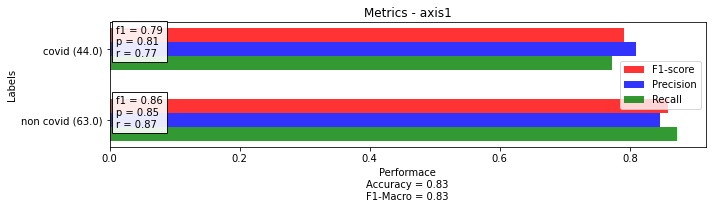

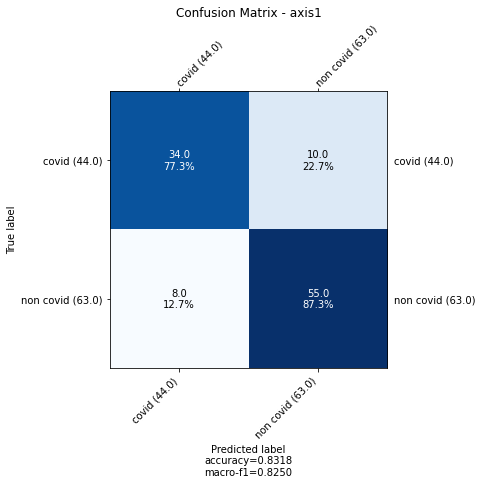

In [13]:
'''
HMV + HCPA
'''
data_train = pd.read_csv("{}/test/test{}.csv".format(STRUCTURE_DATASET_FOLDER, 1))
labels = data_train['covid'].unique()

labels.sort()
labels_length = len(labels)
labels_pos_dict = dict(zip(labels, [i for i in range(labels_length)]))


for axis in SUB_FILE:
    print('\n'+axis+'\n=======================================================================================')
    
    predicted_dir = "{}/".format(OUTPUT_PREDICTED_FOLDER)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    predicted_dir = "{}/{}/".format(OUTPUT_PREDICTED_FOLDER, axis)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    
    
    # Predicted class for patient and fold
    df_axis = pd.DataFrame(columns=['fold', 'patient', 'real', 'predicted', 'count'])
    
    # Generate confusion matrix
    confusion_matrix = np.zeros(labels_length*labels_length).reshape(labels_length, labels_length)

    for n_fold in [4, 5]: # [1, 2, 3, 4, 5]:
#     for n_fold in [j+1 for j in range(5)]:
#     for n_fold in [j+31 for j in range(14)]:
        print("\n\n\nFold", str(n_fold))
        
        data_validation = pd.read_csv("{}/test/test{}.csv".format(STRUCTURE_DATASET_FOLDER, n_fold))
        
        data_validation_dict = dict(zip(data_validation.nome, data_validation.covid))
        
#         model, SELECTED_MODEL = get_model_resnet50()
#         model, SELECTED_MODEL = get_model_vgg16()
        model, SELECTED_MODEL = get_model_vgg16_chico()
        legend_path = "{}/{}/fold{}/{}/legend".format(MODEL_FOLDER, SELECTED_MODEL, n_fold, axis)
        
        model = tf.keras.models.load_model("{}/{}/fold{}/{}/my_checkpoint".format(TRAINING_FOLDER, SELECTED_MODEL, n_fold, axis))
        
        # Test with other patients
        df = predictions_by_patient(model, data_validation['nome'].to_list(), legend_path, axis)
        idx = df.groupby(['patient'])['count'].transform(max) == df['count']
        df = df[idx]
        df.reset_index(drop=True, inplace=True)
        df['fold'] = n_fold
        df['real'] = ''
        last_patient = ''
#         print(labels_pos_dict)
#         print(data_validation_dict)
        for index, row in df.iterrows():
            if row['patient'] != last_patient:
                df.loc[index, 'real'] = data_validation_dict[row['patient']]
                real_label_pos = labels_pos_dict[data_validation_dict[row['patient']]]
                pred_label_pos = labels_pos_dict[row['predicted']]
                confusion_matrix[real_label_pos][pred_label_pos] += 1
            last_patient = row['patient']        
        df_axis = df_axis.append(df)
        del model
    print(df_axis)
        
    predicted_dir = "{}/{}/{}/".format(OUTPUT_PREDICTED_FOLDER, axis, SELECTED_MODEL)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    df_axis.to_csv(predicted_dir+'predicted5.csv', index=False)
    print(labels_pos_dict)
    print(confusion_matrix)
    
    '''
    PRINT METRICS AND CONFUSION MATRIX
    '''
    pm.plot_labels_metrics(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title='Metrics - ' + axis,
                clear_diagonal=False,
                figsize=(15, 105),
                output_file="metrics.png"
            )
    pm.plot_confusion_matrix(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title="Confusion Matrix - " + axis,
                clear_diagonal=False,
                output_file="matrix.png",
                figsize=(10, 7)
#                 verbose=args.verbose,
            )

In [ ]:
# model, SELECTED_MODEL = get_model_resnet50()
model, SELECTED_MODEL = get_model_vgg16()

# model.load_weights('training/resnet50/5fold/axis1/my_checkpoint')
fold = 1
axis = 'axis1'
legend_path = "{}/{}/fold{}/{}/legend".format(MODEL_FOLDER, SELECTED_MODEL, fold, axis)
model.load_weights("{}/{}/fold{}/{}/my_checkpoint".format(TRAINING_FOLDER, SELECTED_MODEL, fold, axis))

# data_test =  ['C77', 'C117', 'C136', 'C80', 'C91', 'C104', 'C62', 'C147', 'C106', 'C68', 'C123', 'C99', 'C129']
# HCPA
# data_test = ['NEG-001', 'NEG-002', 'NEG-003', 'NEG-004', 'NEG-005', 'NEG-006', 'NEG-007', 'NEG-008', 'NEG-009', 
#              'NEG-010', 'NEG-011', 'NEG-012', 'NEG-013', 'NEG-014', 'NEG-015', 'TYP-002', 'TYP-003', 'TYP-004', 
#              'TYP-005', 'TYP-006', 'TYP-007', 'TYP-008', 'TYP-009', 'TYP-010', 'TYP-011', 'TYP-012', 'TYP-013', 
#              'TYP-014', 'TYP-015', 'TYP-016', 'TYP-017', 'TYP-018', 'TYP-019', 'TYP-020', 'TYP-021', 'TYP-022', 
#              'TYP-023', 'TYP-024', 'TYP-025', 'TYP-026', 'TYP-027', 'TYP-028', 'TYP-029', 'TYP-030', 'TYP-031']

# HMV - CT Indeterminados - PCR Negativo
# data_test = ['C8', 'C28', 'C30', 'C31', 'C34', 'C37', 'C38', 'C45', 'C47', 'C54', 'C68', 'C72', 'C84', 'C98', 
#              'C99', 'C109', 'C119', 'C123', 'C129', 'C139', 'C140', 'C148', 'C156']

# HMV - CT Indeterminados - PCR Positivo
# data_test = ['C40', 'C48', 'C57', 'C65', 'C97', 'C107', 'C128']

# HMV - Atípicos
# data_test = ['C9', 'C43', 'C55', 'C56', 'C58', 'C59', 'C64', 'C67', 'C70', 'C73', 'C81', 'C118', 'C122', 'C127', 
#              'C134', 'C141', 'C164']

# HMV - CT Típico - PCR negativo
# data_test = ['C71', 'C101', 'C143', 'C162'] 

# HMV - CT Negativo - PCR positivo
data_test = ['C76', 'C105']

# VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HCPA/exame-pulmao"
VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HMV/exame-pulmao"

df = predictions_by_patient(model, data_test, legend_path, axis)

In [ ]:
'''
HCPA
'''
data_test = ['NEG-001', 'NEG-002', 'NEG-003', 'NEG-004', 'NEG-005', 'NEG-006', 'NEG-007', 'NEG-008', 'NEG-009', 
             'NEG-010', 'NEG-011', 'NEG-012', 'NEG-013', 'NEG-014', 'NEG-015', 'TYP-002', 'TYP-003', 'TYP-004', 
             'TYP-005', 'TYP-006', 'TYP-007', 'TYP-008', 'TYP-009', 'TYP-010', 'TYP-011', 'TYP-012', 'TYP-013', 
             'TYP-014', 'TYP-015', 'TYP-016', 'TYP-017', 'TYP-018', 'TYP-019', 'TYP-020', 'TYP-021', 'TYP-022', 
             'TYP-023', 'TYP-024', 'TYP-025', 'TYP-026', 'TYP-027', 'TYP-028', 'TYP-029', 'TYP-030', 'TYP-031']

for axis in SUB_FILE:
    print('\n'+axis+'\n=====')
    for n_fold in [1, 2, 3, 4, 5]:
        print("\n\n\nFold", str(n_fold))        
#         model, SELECTED_MODEL = get_model_resnet50()
        model, SELECTED_MODEL = get_model_vgg16()
        legend_path = "{}/{}/fold{}/{}/legend".format(MODEL_FOLDER, SELECTED_MODEL, n_fold, axis)
        model.load_weights("{}/{}/fold{}/{}/my_checkpoint".format(TRAINING_FOLDER, SELECTED_MODEL, n_fold, axis))
        
        # Test with other patients
        df = predictions_by_patient(model, data_test, legend_path, axis)
        idx = df.groupby(['patient'])['count'].transform(max) == df['count']
        print(df[idx][['category', 'patient', 'count']].to_string(index=False))

In [3]:
for axis in SUB_FILE:
    print('\n'+axis+'\n=====')
    for n_fold in [j+1 for j in range(5)]:
        print("\n\n\nFold", str(n_fold))        
        #model, SELECTED_MODEL = get_model_resnet50()
        SELECTED_MODEL = 'vgg16'
        df = pd.read_csv("{}/{}/fold{}/{}/history.csv".format(MODEL_FOLDER, SELECTED_MODEL, n_fold, axis))
        print(max(df['val_accuracy']))
        print((df['val_accuracy'].mean()))
#         print(df['val_accuracy'])



axis1
=====



Fold 1
0.8557422757148743
0.8019607782363891



Fold 2
0.8281979560852051
0.7754435181617737



Fold 3
0.7572362422943115
0.7319794595241547



Fold 4
0.8136447072029114
0.7921245455741882



Fold 5
0.837027907371521
0.8220443427562714
